[Epoch 1/150] train_loss=0.9779, val_loss=0.9486
[Epoch 2/150] train_loss=0.9269, val_loss=0.9036
[Epoch 3/150] train_loss=0.8801, val_loss=0.8816
[Epoch 4/150] train_loss=0.8500, val_loss=0.8631
[Epoch 5/150] train_loss=0.8209, val_loss=0.8483
[Epoch 6/150] train_loss=0.7921, val_loss=0.8306
[Epoch 7/150] train_loss=0.7635, val_loss=0.8177
[Epoch 8/150] train_loss=0.7339, val_loss=0.7977
[Epoch 9/150] train_loss=0.7085, val_loss=0.7871
[Epoch 10/150] train_loss=0.6869, val_loss=0.7731
[Epoch 11/150] train_loss=0.6670, val_loss=0.7693
[Epoch 12/150] train_loss=0.6520, val_loss=0.7643
[Epoch 13/150] train_loss=0.6386, val_loss=0.7620
[Epoch 14/150] train_loss=0.6290, val_loss=0.7574
[Epoch 15/150] train_loss=0.6217, val_loss=0.7584
[Epoch 16/150] train_loss=0.6135, val_loss=0.7541
[Epoch 17/150] train_loss=0.6060, val_loss=0.7538
[Epoch 18/150] train_loss=0.5988, val_loss=0.7549
[Epoch 19/150] train_loss=0.5937, val_loss=0.7575
[Epoch 20/150] train_loss=0.5885, val_loss=0.7563
[Epoch 21

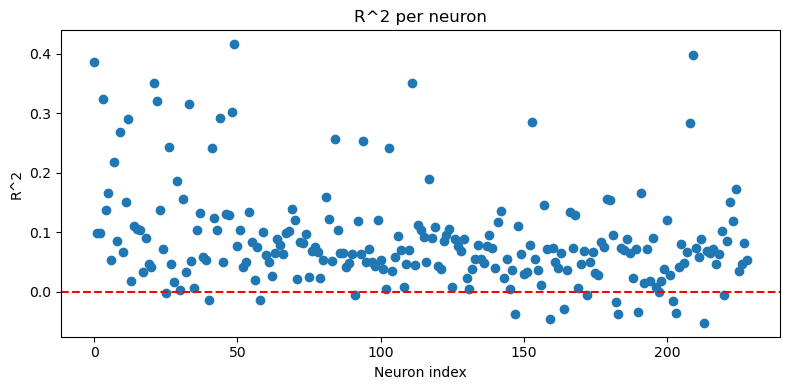

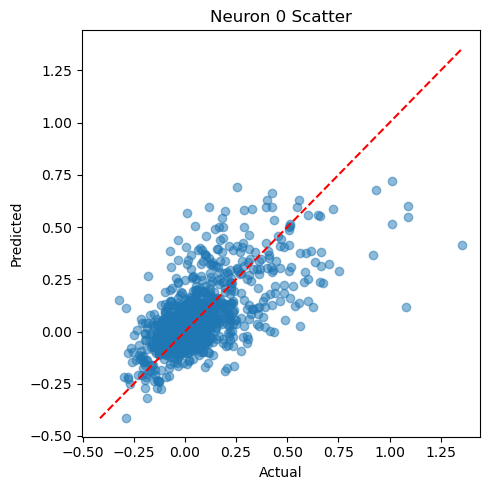

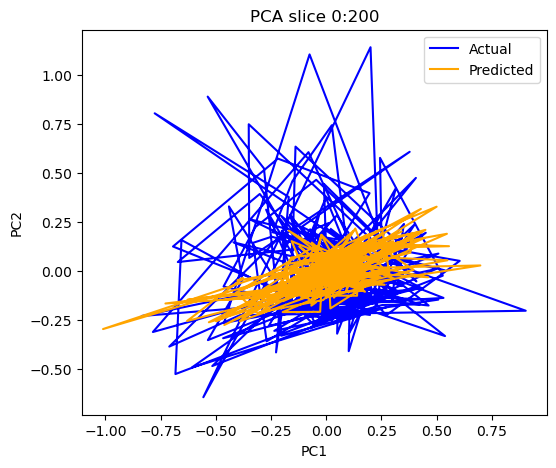

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import scipy.io

###############################################################################
# 1) LOAD DATA
###############################################################################
file_path = "L23_neuron_20210228_Y54_Z320_test.mat"  # Update with the correct path
mat_data = scipy.io.loadmat(file_path)

# Convert MATLAB arrays to NumPy arrays
eigenface_evoked = np.array(mat_data["Eigenface_0_trials_evoked"])  # shape (500, 1000, 4)
eigenface_isi    = np.array(mat_data["Eigenface_0_trials_isi"])     # shape (500, 1000)
dff_evoked       = np.array(mat_data["dFF0_trials_evoked"])         # shape (229, 1000, 4)
dff_isi          = np.array(mat_data["dFF0_trials_isi"])            # shape (229, 1000)

###############################################################################
# 2) DATASET WITH PER-NEURON NORMALIZATION
###############################################################################
class NeuralDataset(Dataset):
    """
    - Each column => one sample (face(500)+stim(4) => 504 input dims).
    - Neural targets => (229,) dimension.
    - We'll do PER-NEURON normalization: For each neuron n, compute mean/std across all samples.

    We also build separate 'train' vs 'test/val' splits by splitting the dataset
    after we gather all samples and do the normalization. But for demonstration,
    we create the entire dataset in one go. Splitting is done externally.
    """

    def __init__(self, eigenface_evoked, dff_evoked,
                 eigenface_isi, dff_isi,
                 per_neuron_stats=None,  # optional (mean, std) from outside
                 apply_norm=True):
        super().__init__()

        self.samples_x = []
        self.samples_y = []

        n_stim = 4
        # ---------- Evoked -------------
        for c in range(n_stim):
            face_data_cond = eigenface_evoked[:, :, c]   # shape (500, 1000)
            neural_data_cond = dff_evoked[:, :, c]       # shape (229, 1000)
            stim_one_hot = np.zeros((n_stim,), dtype=np.float32)
            stim_one_hot[c] = 1.0

            for col in range(face_data_cond.shape[1]):  # 1000
                face_col = face_data_cond[:, col].astype(np.float32)    # (500,)
                neural_col = neural_data_cond[:, col].astype(np.float32)# (229,)
                face_stim = np.concatenate([face_col, stim_one_hot], axis=0)  # (504,)
                self.samples_x.append(face_stim)
                self.samples_y.append(neural_col)

        # ---------- ISI (no stim) -------------
        face_isi  = eigenface_isi  # (500, 1000)
        neural_isi = dff_isi       # (229, 1000)
        zero_stim = np.zeros((n_stim,), dtype=np.float32)

        for col in range(face_isi.shape[1]):  # 1000
            face_col = face_isi[:, col].astype(np.float32)
            neural_col = neural_isi[:, col].astype(np.float32)
            face_stim = np.concatenate([face_col, zero_stim], axis=0)
            self.samples_x.append(face_stim)
            self.samples_y.append(neural_col)

        # Convert to Tensors
        self.samples_x = torch.tensor(np.array(self.samples_x))  # shape (N, 504)
        self.samples_y = torch.tensor(np.array(self.samples_y))  # shape (N, 229)

        # If we want to apply per-neuron normalization:
        if apply_norm:
            if per_neuron_stats is None:
                # Compute mean/std for each neuron
                # shape => (N, 229)
                self.means = self.samples_y.mean(dim=0)    # (229,)
                self.stds  = self.samples_y.std(dim=0)     # (229,)
                # Avoid division by zero
                self.stds  = torch.where(self.stds < 1e-9, torch.ones_like(self.stds), self.stds)
            else:
                self.means, self.stds = per_neuron_stats

            # Normalize each neuron individually
            # shape => (N, 229)
            self.samples_y = (self.samples_y - self.means) / self.stds
        else:
            # no normalization
            self.means = torch.zeros((229,), dtype=torch.float32)
            self.stds  = torch.ones((229,), dtype=torch.float32)

    def __len__(self):
        return self.samples_x.shape[0]

    def __getitem__(self, idx):
        return self.samples_x[idx], self.samples_y[idx]


###############################################################################
# 3) MULTI-BRANCH MLP
###############################################################################
class MultiBranchMLP(nn.Module):
    """
    - One branch for face (500 dims), 
    - One branch for the stimulus (4 dims).
    - Then we concatenate the two branches and go through further layers.
    """

    def __init__(self, face_dim=500, stim_dim=4, hidden_face=[512, 256],
                 hidden_stim=[128], hidden_fuse=[256, 128], output_dim=229):
        super().__init__()
        
        # Face branch
        face_layers = []
        prev_dim = face_dim
        for hdim in hidden_face:
            face_layers.append(nn.Linear(prev_dim, hdim))
            face_layers.append(nn.ReLU())
            prev_dim = hdim
        self.face_branch = nn.Sequential(*face_layers)

        # Stim branch
        stim_layers = []
        prev_dim = stim_dim
        for hdim in hidden_stim:
            stim_layers.append(nn.Linear(prev_dim, hdim))
            stim_layers.append(nn.ReLU())
            prev_dim = hdim
        self.stim_branch = nn.Sequential(*stim_layers)

        # Fusion
        fuse_in = hidden_face[-1] + hidden_stim[-1]
        fuse_layers = []
        prev_dim = fuse_in
        for hdim in hidden_fuse:
            fuse_layers.append(nn.Linear(prev_dim, hdim))
            fuse_layers.append(nn.ReLU())
            prev_dim = hdim

        # Final layer => output_dim
        fuse_layers.append(nn.Linear(prev_dim, output_dim))
        self.fuse = nn.Sequential(*fuse_layers)

    def forward(self, x):
        # x shape: (B, 504) => first 500 are face, last 4 are stim
        face_input = x[:, :500]
        stim_input = x[:, 500:]

        face_out = self.face_branch(face_input)  # (B, hidden_face[-1])
        stim_out = self.stim_branch(stim_input)  # (B, hidden_stim[-1])

        combined = torch.cat([face_out, stim_out], dim=-1)
        out = self.fuse(combined)  # (B, 229)
        return out


###############################################################################
# 4) CORRELATION LOSS + Combined Loss
###############################################################################
def correlation_loss(y_pred, y_true, eps=1e-8):
    # Flatten over batch * 229
    y_pred_f = y_pred.view(-1)
    y_true_f = y_true.view(-1)

    y_pred_mean = torch.mean(y_pred_f)
    y_true_mean = torch.mean(y_true_f)
    y_pred_centered = y_pred_f - y_pred_mean
    y_true_centered = y_true_f - y_true_mean

    cov = torch.sum(y_pred_centered * y_true_centered)
    var1 = torch.sum(y_pred_centered ** 2) + eps
    var2 = torch.sum(y_true_centered ** 2) + eps

    corr = cov / torch.sqrt(var1 * var2)
    return 1.0 - corr

def combined_loss(y_pred, y_true, alpha=0.5):
    mse = torch.mean((y_pred - y_true)**2)
    corr_l = correlation_loss(y_pred, y_true)
    return alpha * mse + (1 - alpha) * corr_l


###############################################################################
# 5) TRAINING + VALIDATION
###############################################################################
def train_model(eigenface_evoked, dff_evoked,
                eigenface_isi, dff_isi,
                epochs=100,
                batch_size=64,
                lr=1e-3,
                alpha=0.3,
                device='cuda'):
    
    # 1) Build the full dataset
    full_dataset = NeuralDataset(eigenface_evoked, dff_evoked,
                                 eigenface_isi, dff_isi,
                                 per_neuron_stats=None,
                                 apply_norm=True)
    N = len(full_dataset)
    # Let's do an 80/20 split for train/val
    val_size = int(0.2 * N)
    train_size = N - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, drop_last=False)

    # 2) Instantiate model
    model = MultiBranchMLP(face_dim=500, stim_dim=4,
                           hidden_face=[1024, 512, 256],   # deeper face branch
                           hidden_stim=[128, 64],          # slightly deeper stim
                           hidden_fuse=[256, 128],
                           output_dim=229).to(device)

    # 3) Optimizer + LR schedule
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                     patience=5, verbose=True)
    # patience=5 => if val loss doesn't improve for 5 epochs, reduce LR by half.

    # 4) Training loop with early stopping
    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0
    max_patience = 700  # if no improvement for 15 consecutive epochs, stop

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            pred = model(batch_x)
            loss = combined_loss(pred, batch_y, alpha=alpha)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        train_loss = total_loss / len(train_loader)

        # Evaluate on validation
        model.eval()
        val_loss_total = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                pred = model(batch_x)
                loss = combined_loss(pred, batch_y, alpha=alpha)
                val_loss_total += loss.item()
        val_loss = val_loss_total / len(val_loader)

        # LR scheduler step
        scheduler.step(val_loss)

        print(f"[Epoch {epoch+1}/{epochs}] train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

        # Check improvement
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print("Early stopping triggered!")
                break

    # Restore best model
    if best_state is not None:
        model.load_state_dict(best_state)
    print(f"Training complete. Best validation loss={best_val_loss:.4f}")

    # Return model + the dataset's per-neuron stats so we can invert normalization
    return model, (full_dataset.means, full_dataset.stds), train_dataset, val_dataset


###############################################################################
# 6) EVALUATION + INVERT NORMALIZATION
###############################################################################
def invert_normalization(y_z, means, stds):
    """
    y_z: shape (batch, 229) in normalized space
    means, stds: shape (229,)
    returns unnormalized y
    """
    # broadcast => (batch, 229)
    return y_z * stds + means

def compute_predictions(model, dataset, means, stds, device='cpu', batch_size=64):
    """
    Runs model on the entire dataset, returning real-scale predictions (N,229) and actual.
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()

    all_preds = []
    all_true  = []

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)  # normalized
            pred_yz = model(batch_x)      # normalized

            # invert
            pred_real = invert_normalization(pred_yz, means, stds)
            true_real = invert_normalization(batch_y, means, stds)
            
            all_preds.append(pred_real.cpu().numpy())
            all_true.append(true_real.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)  # (N, 229)
    all_true  = np.concatenate(all_true, axis=0)  # (N, 229)
    return all_preds, all_true

def compute_r2_per_neuron(all_preds, all_actual):
    """
    Compute R^2 per neuron across all samples (N,229).
    """
    n_samples, n_neurons = all_preds.shape
    r2_values = np.zeros(n_neurons, dtype=np.float32)
    for n in range(n_neurons):
        y_true = all_actual[:, n]
        y_pred = all_preds[:, n]
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        if ss_tot < 1e-12:
            r2_values[n] = 0.0
        else:
            r2_values[n] = 1.0 - ss_res/ss_tot
    return r2_values

def plot_r2_distribution(r2_values):
    plt.figure(figsize=(8,4))
    plt.plot(r2_values, 'o')
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Neuron index")
    plt.ylabel("R^2")
    plt.title("R^2 per neuron")
    plt.tight_layout()
    plt.show()

def plot_scatter_pred_vs_actual(all_preds, all_actual, neuron_id=0, max_points=1000):
    y_true = all_actual[:, neuron_id]
    y_pred = all_preds[:, neuron_id]
    
    if len(y_true) > max_points:
        idxs = np.random.choice(len(y_true), size=max_points, replace=False)
        y_true = y_true[idxs]
        y_pred = y_pred[idxs]

    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Neuron {neuron_id} Scatter")
    mn = min(y_true.min(), y_pred.min())
    mx = max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.tight_layout()
    plt.show()

def plot_pca_trajectory(all_preds, all_actual, start_idx=0, length=200, n_components=2):
    end_idx = min(start_idx + length, all_preds.shape[0])
    actual_slice = all_actual[start_idx:end_idx, :]
    pred_slice   = all_preds[start_idx:end_idx, :]

    pca = PCA(n_components=n_components)
    pca.fit(actual_slice)
    act_pcs = pca.transform(actual_slice)
    pred_pcs= pca.transform(pred_slice)

    if n_components==2:
        plt.figure(figsize=(6,5))
        plt.plot(act_pcs[:,0], act_pcs[:,1], label="Actual", c='b')
        plt.plot(pred_pcs[:,0], pred_pcs[:,1], label="Predicted", c='orange')
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.legend()
        plt.title(f"PCA slice {start_idx}:{end_idx}")
        plt.show()
    elif n_components==3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(7,6))
        ax=fig.add_subplot(111, projection='3d')
        ax.plot(act_pcs[:,0], act_pcs[:,1], act_pcs[:,2], label="Actual", c='b')
        ax.plot(pred_pcs[:,0], pred_pcs[:,1], pred_pcs[:,2], label="Predicted", c='orange')
        ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
        plt.legend()
        plt.show()

###############################################################################
# 7) MAIN
###############################################################################
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Train with deeper model, combined loss, more epochs, LR schedule
    model, (means, stds), train_dataset, val_dataset = train_model(
        eigenface_evoked, dff_evoked,
        eigenface_isi, dff_isi,
        epochs=150,       # more epochs
        batch_size=64,
        lr=1e-3,
        alpha=0.5,
        device=device
    )
    
    # Evaluate on train set
    train_preds, train_true = compute_predictions(model, train_dataset, means, stds, device=device)
    r2_train = compute_r2_per_neuron(train_preds, train_true)
    print(f"Train R^2 mean={r2_train.mean():.3f}, median={np.median(r2_train):.3f}")

    # Evaluate on val set
    val_preds, val_true = compute_predictions(model, val_dataset, means, stds, device=device)
    r2_val = compute_r2_per_neuron(val_preds, val_true)
    print(f"Val R^2 mean={r2_val.mean():.3f}, median={np.median(r2_val):.3f}")

    # Plot distribution of R^2 on val set
    plot_r2_distribution(r2_val)

    # Example scatter for neuron 0
    plot_scatter_pred_vs_actual(val_preds, val_true, neuron_id=0, max_points=1000)

    # PCA on a slice of val data
    plot_pca_trajectory(val_preds, val_true, start_idx=0, length=200, n_components=2)

Fitting PCA on neural (229D) -> top 128 PCs.
Dataset size = 5000. PCA explained variance (first 3 PCs): [0.0446278  0.04104515 0.02837527]
Epoch 0/50, train_loss=31.4082, test_loss=0.5176
Epoch 20/50, train_loss=0.0158, test_loss=0.0129
Epoch 40/50, train_loss=0.0154, test_loss=0.0133
Early stopping triggered.
Final var explained (R^2) in PC space: -0.2139, test_loss=0.0123


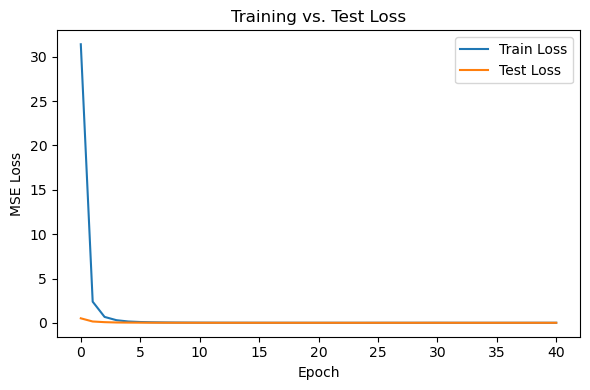

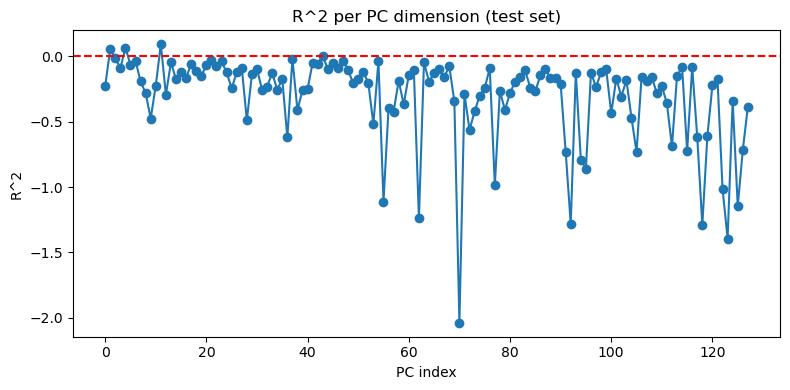

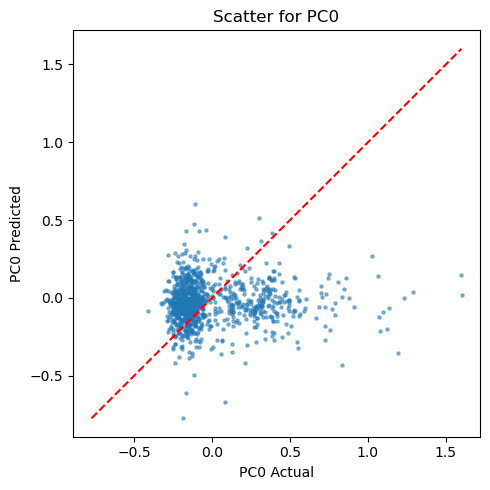

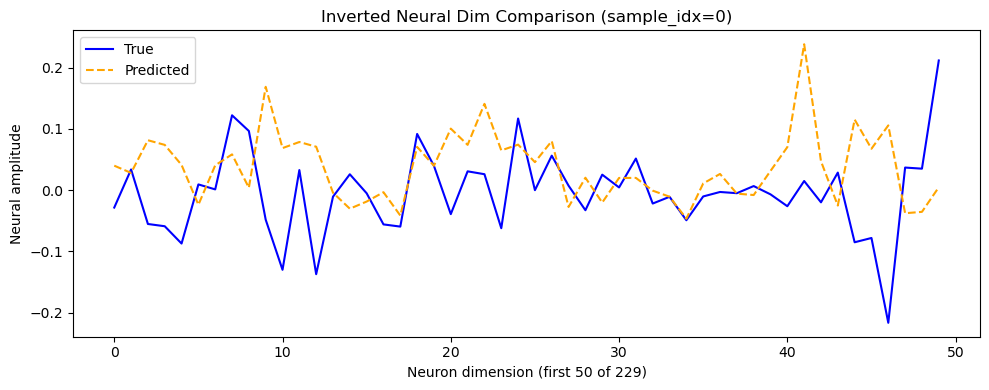

In [14]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt  # NEW: for plotting
import scipy.io

##############################################################################
# 1) LOAD MAT DATA
##############################################################################
file_path = "L23_neuron_20210228_Y54_Z320_test.mat"  # Adjust path if needed
mat_data = scipy.io.loadmat(file_path)

eigenface_evoked = np.array(mat_data["Eigenface_0_trials_evoked"])  # (500, 1000, 4)
eigenface_isi    = np.array(mat_data["Eigenface_0_trials_isi"])     # (500, 1000)
dff_evoked       = np.array(mat_data["dFF0_trials_evoked"])         # (229, 1000, 4)
dff_isi          = np.array(mat_data["dFF0_trials_isi"])            # (229, 1000)

##############################################################################
# 2) DATASET FOR PCA
##############################################################################
class PCADataset(Dataset):
    def __init__(self, eigenface_evoked, dff_evoked,
                 eigenface_isi, dff_isi, n_pcs=128, device="cpu"):
        super().__init__()
        self.n_pcs = n_pcs
        self.samples_x = []
        self.samples_y_raw = []  # shape (229,)

        n_stim = 4
        face_dim = 500

        # Evoked
        for c in range(n_stim):
            face_cond   = eigenface_evoked[:, :, c]  # (500, 1000)
            neural_cond = dff_evoked[:, :, c]        # (229, 1000)
            stim_vec = np.zeros((n_stim,), dtype=np.float32)
            stim_vec[c] = 1.0
            for col in range(face_cond.shape[1]):
                face_col   = face_cond[:, col].astype(np.float32)
                neural_col = neural_cond[:, col].astype(np.float32)
                x_input = np.concatenate([face_col, stim_vec], axis=0)  # (504,)
                self.samples_x.append(x_input)
                self.samples_y_raw.append(neural_col)

        # ISI: no stim
        face_isi_data   = eigenface_isi
        neural_isi_data = dff_isi
        zero_stim = np.zeros((n_stim,), dtype=np.float32)
        for col in range(face_isi_data.shape[1]):
            face_col   = face_isi_data[:, col].astype(np.float32)
            neural_col = neural_isi_data[:, col].astype(np.float32)
            x_input = np.concatenate([face_col, zero_stim], axis=0)
            self.samples_x.append(x_input)
            self.samples_y_raw.append(neural_col)

        # Convert to arrays
        self.samples_x = np.array(self.samples_x)         # (N, 504)
        self.samples_y_raw = np.array(self.samples_y_raw) # (N, 229)

        print(f"Fitting PCA on neural (229D) -> top {n_pcs} PCs.")
        self.pca = PCA(n_components=n_pcs)
        self.pca.fit(self.samples_y_raw)  # shape (N,229)

        pcs_projected = self.pca.transform(self.samples_y_raw)  # (N,n_pcs)

        self.X = torch.tensor(self.samples_x, dtype=torch.float32, device=device)
        self.Y = torch.tensor(pcs_projected, dtype=torch.float32, device=device)

        print(f"Dataset size = {len(self.X)}. PCA explained variance (first 3 PCs):",
              self.pca.explained_variance_ratio_[:3])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def invert_pcs(self, pcs: np.ndarray):
        """Convert from predicted PCs => approximate original 229D neural."""
        return self.pca.inverse_transform(pcs)

##############################################################################
# 3) CORE + READOUT
##############################################################################
class Core(nn.Module):
    def __init__(self, in_dim=504, n_latents=256):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, n_latents),
        )
    def forward(self, x):
        latents = self.features(x)
        return latents

class Readout(nn.Module):
    def __init__(self, n_latents=256, n_out=128):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(n_latents, n_out)
        )
    def forward(self, latents):
        return self.features(latents)

##############################################################################
# 4) KEYPOINTS NETWORK W/ TRAINING LOOP + LOGGING
##############################################################################
class KeypointsNetwork(nn.Module):
    def __init__(self,
                 in_dim=504,
                 n_latents=256,
                 n_out=128,
                 smoothing_penalty=0.5):
        super().__init__()
        self.core = Core(in_dim=in_dim, n_latents=n_latents)
        self.readout = Readout(n_latents=n_latents, n_out=n_out)
        self.smoothing_penalty = smoothing_penalty

        # We'll store train/test loss for plotting
        self.train_losses = []
        self.test_losses  = []

    def forward(self, x):
        latents = self.core(x)
        y_pred = self.readout(latents)
        return y_pred, latents

    def train_model(self,
                    train_loader,
                    test_loader,
                    n_iter=300,
                    learning_rate=1e-3,
                    weight_decay=1e-4,
                    device="cuda",
                    verbose=True):
        optimizer = optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        best_test_loss = float('inf')
        best_state = None
        patience = 10
        patience_counter = 0

        for epoch in range(n_iter):
            self.train()
            epoch_loss = 0.0
            for (x_batch, y_batch) in train_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred, _ = self.forward(x_batch)
                loss = ((y_pred - y_batch)**2).mean()

                # Smoothing penalty
                # In our MLP: self.core.features => [Linear, ReLU, Linear].
                # The second Linear is self.core.features[2].
                if isinstance(self.core.features[2], nn.Linear):
                    w = self.core.features[2].weight
                    diff = torch.diff(w, dim=0)
                    loss += self.smoothing_penalty * (diff**2).sum()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            epoch_loss /= len(train_loader)

            # Evaluate on test set
            test_loss = 0.0
            self.eval()
            with torch.no_grad():
                for (x_test, y_test) in test_loader:
                    x_test = x_test.to(device)
                    y_test = y_test.to(device)
                    y_pred, _ = self.forward(x_test)
                    l = ((y_pred - y_test)**2).mean()
                    test_loss += l.item()
            test_loss /= len(test_loader)

            self.train_losses.append(epoch_loss)
            self.test_losses.append(test_loss)

            if verbose and (epoch % 20 == 0 or epoch == n_iter - 1):
                print(f"Epoch {epoch}/{n_iter}, train_loss={epoch_loss:.4f}, test_loss={test_loss:.4f}")

            # Early stopping
            if test_loss < best_test_loss - 1e-6:
                best_test_loss = test_loss
                best_state = self.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    if verbose:
                        print("Early stopping triggered.")
                    break

        if best_state is not None:
            self.load_state_dict(best_state)

        return best_test_loss

##############################################################################
# 5) UTILS FOR VARIANCE EXPLAINED
##############################################################################
def variance_explained(y_true, y_pred):
    """
    y_true, y_pred: shape (N, n_pcs)
    returns scalar fraction of variance explained
    """
    mse = ((y_true - y_pred)**2).mean()
    var_y = (y_true - y_true.mean(axis=0)).pow(2).mean()
    if var_y.item() < 1e-12:
        return 0.0
    return (1.0 - mse/var_y).item()

##############################################################################
# 6) TRAIN & EVAL + PLOTTING
##############################################################################
def train_and_evaluate(n_pcs=128,
                       epochs=50,
                       batch_size=64,
                       lr=1e-3,
                       smoothing_penalty=0.5,
                       device="cuda"):

    device = torch.device(device if torch.cuda.is_available() else "cpu")

    # 1) Dataset
    ds = PCADataset(eigenface_evoked, dff_evoked,
                    eigenface_isi, dff_isi,
                    n_pcs=n_pcs, device=device)
    N = len(ds)

    # 80/20 split
    val_size = int(0.2*N)
    train_size = N - val_size
    train_ds, test_ds = random_split(ds, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # 2) Build model
    model = KeypointsNetwork(in_dim=504,
                             n_latents=256,
                             n_out=n_pcs,
                             smoothing_penalty=smoothing_penalty
                            ).to(device)

    # 3) Train
    best_test_loss = model.train_model(train_loader, test_loader,
                                       n_iter=epochs,
                                       learning_rate=lr,
                                       weight_decay=1e-4,
                                       device=device,
                                       verbose=True)

    # 4) Evaluate final R^2
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for (x_test, y_test) in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            y_pred, _ = model.forward(x_test)
            all_preds.append(y_pred.cpu())
            all_targets.append(y_test.cpu())
    all_preds   = torch.cat(all_preds, dim=0)   # (val_size, n_pcs)
    all_targets = torch.cat(all_targets, dim=0) # (val_size, n_pcs)
    r2 = variance_explained(all_targets, all_preds)

    print(f"Final var explained (R^2) in PC space: {r2:.4f}, test_loss={best_test_loss:.4f}")

    # 5) PLOTTING EXAMPLES
    plot_training_curves(model)
    plot_r2_per_pc(model, ds, test_ds, device)
    plot_scatter_for_pc(model, ds, test_ds, device, pc_idx=0)
    plot_inverted_example(model, ds, test_ds, device, sample_idx=0)

    return model, ds, train_ds, test_ds


##############################################################################
# 7) PLOTTING FUNCTIONS
##############################################################################

def plot_training_curves(model):
    """
    Plots the train vs. test loss across epochs, stored in model.train_losses/test_losses.
    """
    epochs = range(len(model.train_losses))
    plt.figure(figsize=(6,4))
    plt.plot(epochs, model.train_losses, label='Train Loss')
    plt.plot(epochs, model.test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training vs. Test Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_r2_per_pc(model, dataset, subset_dataset, device, batch_size=64):
    """
    For each PC dimension, compute R^2. 
    We'll do a loop so we can see if early PCs are better predicted than later ones.
    """
    loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=False)
    model.eval()

    all_preds, all_targets = [], []
    with torch.no_grad():
        for (x_test, y_test) in loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            y_pred, _ = model.forward(x_test)
            all_preds.append(y_pred.cpu())
            all_targets.append(y_test.cpu())
    all_preds   = torch.cat(all_preds, dim=0).numpy()   # shape (N, n_pcs)
    all_targets = torch.cat(all_targets, dim=0).numpy()

    n_pcs = dataset.n_pcs
    r2_values = []
    for pc_idx in range(n_pcs):
        y_true = all_targets[:, pc_idx]
        y_pred = all_preds[:, pc_idx]
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        if ss_tot < 1e-12:
            r2_values.append(0.0)
        else:
            r2_values.append(1.0 - ss_res/ss_tot)

    plt.figure(figsize=(8,4))
    plt.plot(r2_values, marker='o')
    plt.axhline(0, color='r', linestyle='--')
    plt.title('R^2 per PC dimension (test set)')
    plt.xlabel('PC index')
    plt.ylabel('R^2')
    plt.tight_layout()
    plt.show()


def plot_scatter_for_pc(model, dataset, subset_dataset, device, pc_idx=0, max_points=1000):
    """
    Scatter plot of predicted vs actual for a single PC dimension across the subset (test or train).
    """
    loader = DataLoader(subset_dataset, batch_size=64, shuffle=False)
    model.eval()

    y_trues = []
    y_preds = []
    with torch.no_grad():
        for x_test, y_test in loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            y_pred, _ = model.forward(x_test)
            y_trues.append(y_test[:, pc_idx].cpu())
            y_preds.append(y_pred[:, pc_idx].cpu())

    y_trues = torch.cat(y_trues, dim=0).numpy()
    y_preds = torch.cat(y_preds, dim=0).numpy()

    if len(y_trues) > max_points:
        idxs = np.random.choice(len(y_trues), size=max_points, replace=False)
        y_trues = y_trues[idxs]
        y_preds = y_preds[idxs]

    plt.figure(figsize=(5,5))
    plt.scatter(y_trues, y_preds, s=5, alpha=0.5)
    mn = min(y_trues.min(), y_preds.min())
    mx = max(y_trues.max(), y_preds.max())
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel(f'PC{pc_idx} Actual')
    plt.ylabel(f'PC{pc_idx} Predicted')
    plt.title(f'Scatter for PC{pc_idx}')
    plt.tight_layout()
    plt.show()


def plot_inverted_example(model, dataset, subset_dataset, device, sample_idx=0):
    """
    We'll take one sample from the subset dataset, run it through the model, 
    get predicted PCs, and invert them to 229D neural space. 
    Then compare to the actual 229D for that sample.
    We'll just do a line plot of the 229D for demonstration.
    """
    # get the single sample from the subset
    # if sample_idx is bigger than the subset, we clamp it
    if sample_idx >= len(subset_dataset):
        sample_idx = len(subset_dataset) - 1

    x_sample, y_sample = subset_dataset[sample_idx]  # (504,), (n_pcs,)
    x_input = x_sample.unsqueeze(0).to(device)  # (1, 504)
    y_input = y_sample.unsqueeze(0).to(device)  # (1, n_pcs)

    model.eval()
    with torch.no_grad():
        y_pred, _ = model.forward(x_input)
    # shape (1, n_pcs)
    pcs_pred = y_pred.squeeze(0).cpu().numpy()
    pcs_true = y_sample.cpu().numpy()

    # invert to 229D
    neural_pred_229 = dataset.invert_pcs(pcs_pred.reshape(1, -1))[0]  # shape (229,)
    neural_true_229 = dataset.invert_pcs(pcs_true.reshape(1, -1))[0]

    # let's do a simple line plot of the first ~50 dimensions to keep it readable
    num_dims_plot = 50
    dims = np.arange(num_dims_plot)

    plt.figure(figsize=(10,4))
    plt.plot(dims, neural_true_229[:num_dims_plot], label='True', color='blue')
    plt.plot(dims, neural_pred_229[:num_dims_plot], label='Predicted', color='orange', linestyle='--')
    plt.xlabel('Neuron dimension (first 50 of 229)')
    plt.ylabel('Neural amplitude')
    plt.title(f'Inverted Neural Dim Comparison (sample_idx={sample_idx})')
    plt.legend()
    plt.tight_layout()
    plt.show()

##############################################################################
# 8) MAIN
##############################################################################
if __name__ == "__main__":
    model, ds_full, train_ds, test_ds = train_and_evaluate(
        n_pcs=128,
        epochs=50,
        batch_size=64,
        lr=1e-3,
        smoothing_penalty=0.5,
        device="cuda"
    )


Fitting PCA on neural data -> top 128 PCs.
Total samples: 5000
Explained var ratio (first 3 PCs): [0.04462776 0.04104508 0.02837522]
Epoch 1/500, Loss=0.011733, R^2=-0.0703
Epoch 2/500, Loss=0.010809, R^2=0.0140
Epoch 3/500, Loss=0.010499, R^2=0.0423
Epoch 4/500, Loss=0.010138, R^2=0.0752
Epoch 5/500, Loss=0.009754, R^2=0.1102
Epoch 6/500, Loss=0.009341, R^2=0.1479
Epoch 7/500, Loss=0.008940, R^2=0.1845
Epoch 8/500, Loss=0.008542, R^2=0.2208
Epoch 9/500, Loss=0.008175, R^2=0.2542
Epoch 10/500, Loss=0.007812, R^2=0.2873
Epoch 11/500, Loss=0.007473, R^2=0.3183
Epoch 12/500, Loss=0.007135, R^2=0.3491
Epoch 13/500, Loss=0.006818, R^2=0.3780
Epoch 14/500, Loss=0.006558, R^2=0.4018
Epoch 15/500, Loss=0.006337, R^2=0.4219
Epoch 16/500, Loss=0.006096, R^2=0.4439
Epoch 17/500, Loss=0.005882, R^2=0.4634
Epoch 18/500, Loss=0.005702, R^2=0.4798
Epoch 19/500, Loss=0.005516, R^2=0.4968
Epoch 20/500, Loss=0.005360, R^2=0.5111
Epoch 21/500, Loss=0.005199, R^2=0.5257
Epoch 22/500, Loss=0.005050, R^2=0.

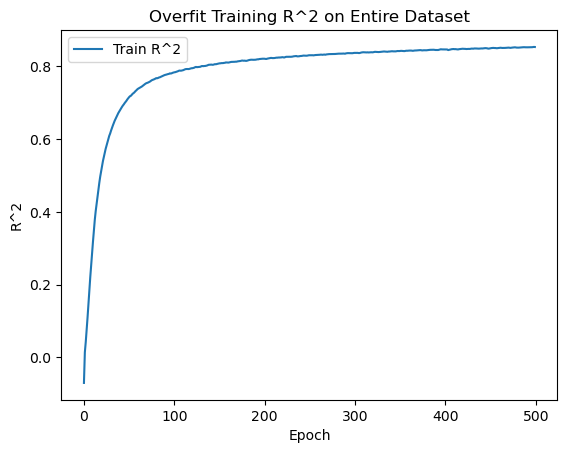

In [1]:
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

##############################################
# 1) LOAD THE .MAT FILE
##############################################
file_path = "L23_neuron_20210228_Y54_Z320_test.mat"  # Adjust path if needed
mat_data = scipy.io.loadmat(file_path)

eigenface_evoked = np.array(mat_data["Eigenface_0_trials_evoked"])  # (500, 1000, 4)
eigenface_isi    = np.array(mat_data["Eigenface_0_trials_isi"])     # (500, 1000)
dff_evoked       = np.array(mat_data["dFF0_trials_evoked"])         # (229, 1000, 4)
dff_isi          = np.array(mat_data["dFF0_trials_isi"])            # (229, 1000)

##############################################
# 2) DATASET for overfitting
##############################################
class PCADataset(Dataset):
    """
    We gather all samples (face+stim -> neural) in one dataset (no splitting).
    Then do PCA on neural from 229D -> n_pcsD.
    """
    def __init__(self,
                 eigenface_evoked, dff_evoked,
                 eigenface_isi, dff_isi,
                 n_pcs=128):
        super().__init__()
        self.n_pcs = n_pcs

        # Collect face+stim inputs and neural raw (229D)
        face_list = []
        neural_list = []

        face_dim = 500
        n_stim = 4

        # Evoked
        for c in range(n_stim):
            face_block   = eigenface_evoked[:, :, c]  # (500, 1000)
            neural_block = dff_evoked[:, :, c]        # (229, 1000)
            stim_onehot = np.zeros((n_stim,), dtype=np.float32)
            stim_onehot[c] = 1.0
            for col in range(face_block.shape[1]):
                face_col   = face_block[:, col].astype(np.float32)
                neural_col = neural_block[:, col].astype(np.float32)
                x_input = np.concatenate([face_col, stim_onehot], axis=0)  # (504,)
                face_list.append(x_input)
                neural_list.append(neural_col)

        # ISI => no stim
        face_isi_block   = eigenface_isi  # (500, 1000)
        neural_isi_block = dff_isi        # (229, 1000)
        zero_stim = np.zeros((n_stim,), dtype=np.float32)
        for col in range(face_isi_block.shape[1]):
            face_col   = face_isi_block[:, col].astype(np.float32)
            neural_col = neural_isi_block[:, col].astype(np.float32)
            x_input = np.concatenate([face_col, zero_stim], axis=0)
            face_list.append(x_input)
            neural_list.append(neural_col)

        self.X_raw = np.array(face_list, dtype=np.float32)    # (N, 504)
        self.Y_raw = np.array(neural_list, dtype=np.float32)  # (N, 229)

        # Fit PCA => project neural from 229D -> n_pcsD
        print("Fitting PCA on neural data -> top", n_pcs, "PCs.")
        self.pca = PCA(n_components=n_pcs)
        self.pca.fit(self.Y_raw)
        pcs = self.pca.transform(self.Y_raw)  # (N, n_pcs)

        self.X = torch.tensor(self.X_raw, dtype=torch.float32)
        self.Y = torch.tensor(pcs,     dtype=torch.float32)

        # We'll store the global mean of Y so we can do a mean-skip final
        self.global_mean = self.Y.mean(dim=0).numpy()  # shape (n_pcs,)

        print("Total samples:", len(self.X))
        print("Explained var ratio (first 3 PCs):", self.pca.explained_variance_ratio_[:3])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def invert_pcs(self, Y_pcs):
        """
        Invert from n_pcsD back to 229D using self.pca.
        Y_pcs: shape (..., n_pcs)
        """
        if isinstance(Y_pcs, torch.Tensor):
            Y_pcs = Y_pcs.detach().cpu().numpy()
        # shape -> (any, n_pcs)
        return self.pca.inverse_transform(Y_pcs)


##############################################
# 3) DEEP MULTI-BRANCH MLP w/ MEAN-SKIP
##############################################
class DeepMultiBranchMeanSkip(nn.Module):
    """
    A big network that can easily overfit. 
    - face branch: multiple layers
    - stim branch: multiple layers
    - fuse: multiple layers
    - final offset + global_mean
    """
    def __init__(self,
                 face_dim=500,
                 stim_dim=4,
                 hidden_face=[2048, 1024, 512],
                 hidden_stim=[128, 64],
                 hidden_fuse=[512, 256, 128],
                 n_pcs=128,
                 global_mean=None):
        super().__init__()
        self.n_pcs = n_pcs

        # Register a buffer for the global mean, shape (n_pcs,)
        if global_mean is None:
            global_mean = np.zeros((n_pcs,), dtype=np.float32)
        self.register_buffer("global_mean", torch.tensor(global_mean, requires_grad=False))

        # Face branch
        self.face_layers = nn.Sequential()
        in_dim = face_dim
        for i, hdim in enumerate(hidden_face):
            self.face_layers.add_module(f"fcf_{i}", nn.Linear(in_dim, hdim))
            self.face_layers.add_module(f"relu_f_{i}", nn.ReLU())
            in_dim = hdim

        # Stim branch
        self.stim_layers = nn.Sequential()
        in_dim_s = stim_dim
        for j, hdim in enumerate(hidden_stim):
            self.stim_layers.add_module(f"fcs_{j}", nn.Linear(in_dim_s, hdim))
            self.stim_layers.add_module(f"relu_s_{j}", nn.ReLU())
            in_dim_s = hdim

        # Fusion
        fuse_in = hidden_face[-1] + hidden_stim[-1]
        self.fuse_layers = nn.Sequential()
        in_dim_f = fuse_in
        for k, hdim in enumerate(hidden_fuse):
            self.fuse_layers.add_module(f"fcfu_{k}", nn.Linear(in_dim_f, hdim))
            self.fuse_layers.add_module(f"relu_fu_{k}", nn.ReLU())
            in_dim_f = hdim

        # Final
        self.final_layer = nn.Linear(in_dim_f, n_pcs)

    def forward(self, x):
        face_input = x[:, :500]
        stim_input = x[:, 500:]

        # face -> face_layers
        out_f = self.face_layers(face_input)
        # stim -> stim_layers
        out_s = self.stim_layers(stim_input)
        # fuse
        combined = torch.cat([out_f, out_s], dim=-1)
        fused = self.fuse_layers(combined)

        # offset
        offset = self.final_layer(fused)
        # add global_mean => final
        final = offset + self.global_mean.unsqueeze(0)  # shape (B, n_pcs)
        return final


##############################################
# 4) TRAINING (OVERFIT) ON FULL DATASET
##############################################
def train_overfit(dataset,
                  epochs=200,
                  batch_size=32,
                  lr=1e-4,
                  device='cuda'):
    """
    We'll just train on the entire dataset. 
    This code aims to drive training R^2 close to 1 (complete overfitting).
    """
    # DataLoader for entire dataset
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Build the big model
    model = DeepMultiBranchMeanSkip(
        face_dim=500,
        stim_dim=4,
        hidden_face=[2048, 1024, 512],
        hidden_stim=[128, 64],
        hidden_fuse=[512, 256, 128],
        n_pcs=dataset.n_pcs,
        global_mean=dataset.global_mean
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # We'll track training R^2 each epoch
    train_r2_list = []

    def compute_r2(Y_true, Y_pred):
        # Y_true, Y_pred => shape (N, n_pcs)
        # R^2 = 1 - MSE / var
        mse = ((Y_true - Y_pred)**2).mean().item()
        var = (Y_true - Y_true.mean(dim=0)).pow(2).mean().item()
        if var < 1e-12:
            return 0.0
        return 1.0 - mse/var

    # Overfit loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        # We'll accumulate all predictions for R^2
        all_preds = []
        all_targets = []
        for (x_batch, y_batch) in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * x_batch.size(0)

            all_preds.append(preds.detach())
            all_targets.append(y_batch)

        # compute R^2 after epoch
        epoch_loss /= len(dataset)
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
        train_r2 = compute_r2(all_targets, all_preds)
        train_r2_list.append(train_r2)

        print(f"Epoch {epoch+1}/{epochs}, Loss={epoch_loss:.6f}, R^2={train_r2:.4f}")

        # if we want to forcibly converge, we can stop if R^2 is near 1
        if train_r2 > 0.999:
            print("Reached near-perfect R^2; stopping early.")
            break

    return model, train_r2_list


##############################################
# 5) MAIN
##############################################
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 1) Build the dataset (over the entire data)
    n_pcs = 128
    ds = PCADataset(eigenface_evoked, dff_evoked, eigenface_isi, dff_isi, n_pcs=n_pcs)

    # 2) Train (overfit)
    model, train_r2_list = train_overfit(ds, epochs=500, batch_size=32, lr=1e-4, device=device)

    # 3) Plot final training R^2
    plt.figure()
    plt.plot(train_r2_list, label="Train R^2")
    plt.xlabel("Epoch")
    plt.ylabel("R^2")
    plt.title("Overfit Training R^2 on Entire Dataset")
    plt.legend()
    plt.show()

    # If you like, you can invert some predictions to 229D and visualize
    # for example:
    # x_sample, y_sample = ds[0]
    # x_t = x_sample.unsqueeze(0).to(device)
    # pred_pcs = model(x_t)
    # # invert back to 229D
    # pred_229 = ds.invert_pcs(pred_pcs.cpu().detach().numpy())
    # print("Predicted 229D shape:", pred_229.shape)


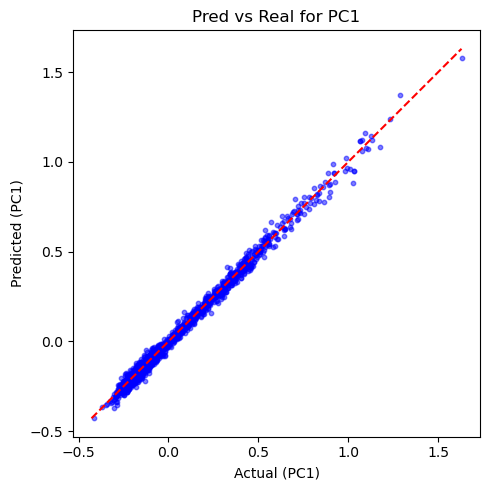

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader

def plot_pred_vs_real_pc0(model, dataset, device='cuda', max_points=1000):
    """
    Plot predicted vs. actual values for the *first* PC (PC index=0) across all samples.
    If the dataset is large, we can subsample to max_points for clarity.
    """
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model.eval()

    all_preds = []
    all_true  = []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(x_batch)  # shape (B, n_pcs)
            all_preds.append(preds.cpu().numpy())
            all_true.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)  # (N, n_pcs)
    all_true  = np.concatenate(all_true,  axis=0)  # (N, n_pcs)

    # We'll pick pc_idx=0
    y_pred_pc0 = all_preds[:, 0]
    y_true_pc0 = all_true[:, 0]

    # Optionally subsample
    N = len(y_true_pc0)
    if N > max_points:
        idxs = np.random.choice(N, size=max_points, replace=False)
        y_pred_pc0 = y_pred_pc0[idxs]
        y_true_pc0 = y_true_pc0[idxs]

    plt.figure(figsize=(5,5))
    plt.scatter(y_true_pc0, y_pred_pc0, s=10, alpha=0.5, c='blue')
    # identity line
    mn = min(y_true_pc0.min(), y_pred_pc0.min())
    mx = max(y_true_pc0.max(), y_pred_pc0.max())
    plt.plot([mn, mx], [mn, mx], color='r', linestyle='--')
    plt.xlabel("Actual (PC1)")
    plt.ylabel("Predicted (PC1)")
    plt.title("Pred vs Real for PC1")
    plt.tight_layout()
    plt.show()
    
plot_pred_vs_real_pc0(model, ds, device=device, max_points=2000)


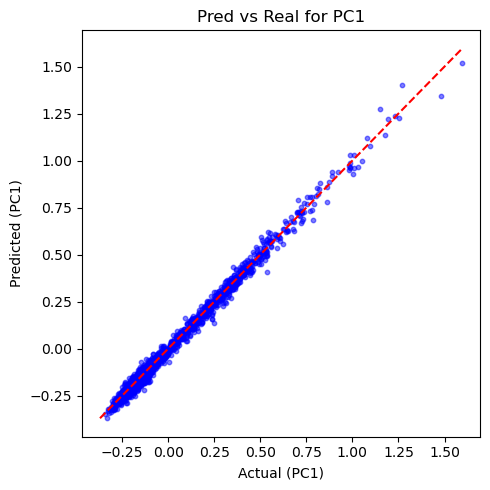

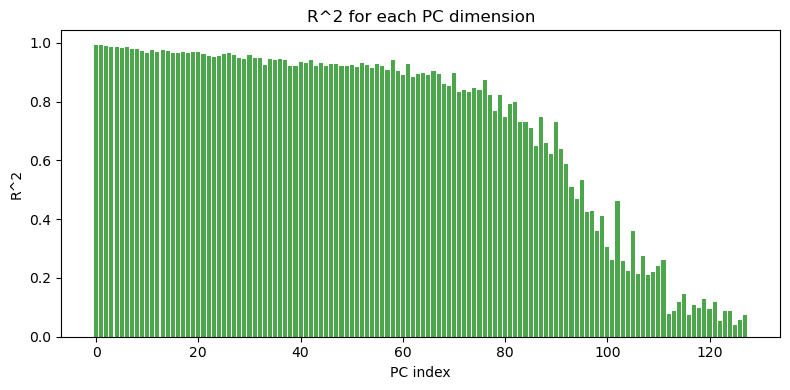

R^2 per PC dimension: [0.99277955 0.99336416 0.98963517 0.9867354  0.9860188  0.9819146
 0.98534584 0.9804244  0.97791314 0.9734704  0.9656653  0.97613084
 0.9709221  0.97523415 0.9726531  0.96484417 0.96422833 0.969808
 0.96458757 0.9683727  0.9678342  0.96164054 0.95725065 0.95319074
 0.956298   0.9626645  0.9674416  0.9586942  0.95026696 0.94481903
 0.9580866  0.94797134 0.9490953  0.9259973  0.94545287 0.9408941
 0.9460101  0.9411487  0.92015845 0.9200563  0.9362115  0.931845
 0.94159454 0.9207843  0.9332113  0.9212501  0.92690176 0.9290025
 0.9207785  0.92285216 0.92480695 0.9184615  0.9314073  0.92533386
 0.91429067 0.92938805 0.9225904  0.9087585  0.94049335 0.9034518
 0.8910624  0.9267731  0.8826369  0.89346004 0.8988793  0.8918687
 0.9031739  0.8940113  0.8597651  0.85294914 0.89853734 0.83346826
 0.8398855  0.83436537 0.8483367  0.83901536 0.87560636 0.8222592
 0.7693237  0.82395333 0.7483201  0.79123116 0.797914   0.7305802
 0.7304914  0.7114874  0.64970016 0.7463188  0.6597

In [3]:
def plot_r2_per_pc(model, dataset, device='cuda'):
    """
    Compute R^2 for each PC dimension and plot them.
    """
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model.eval()

    # Accumulate predictions & targets
    all_preds = []
    all_true  = []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(x_batch)  # (B, n_pcs)
            all_preds.append(preds.cpu().numpy())
            all_true.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)  # shape (N, n_pcs)
    all_true  = np.concatenate(all_true,  axis=0)

    n_pcs = dataset.n_pcs
    r2_vals = np.zeros(n_pcs, dtype=np.float32)

    for pc_idx in range(n_pcs):
        y_t = all_true[:, pc_idx]
        y_p = all_preds[:, pc_idx]
        ss_res = np.sum((y_t - y_p)**2)
        ss_tot = np.sum((y_t - y_t.mean())**2)
        if ss_tot < 1e-12:
            r2_vals[pc_idx] = 0.0
        else:
            r2_vals[pc_idx] = 1.0 - ss_res / ss_tot

    # Plot
    plt.figure(figsize=(8,4))
    plt.bar(np.arange(n_pcs), r2_vals, alpha=0.7, color='green')
    plt.xlabel("PC index")
    plt.ylabel("R^2")
    plt.title("R^2 for each PC dimension")
    plt.tight_layout()
    plt.show()

    return r2_vals
    
if __name__ == "__main__":
    # ... training code ...
    # Suppose 'model' is your final trained model, 'ds' is the dataset.

    # 1) Plot predicted vs actual for the first PC
    plot_pred_vs_real_pc0(model, ds, device=device, max_points=2000)

    # 2) Plot R^2 for every PC dimension
    r2_vals = plot_r2_per_pc(model, ds, device=device)
    print("R^2 per PC dimension:", r2_vals)



In [4]:
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


##############################################
# 1) LOAD THE .MAT FILE
##############################################
file_path = "L23_neuron_20210228_Y54_Z320_test.mat"  # Adjust path if needed
mat_data = scipy.io.loadmat(file_path)

eigenface_evoked = np.array(mat_data["Eigenface_0_trials_evoked"])  # (500, 1000, 4)
eigenface_isi    = np.array(mat_data["Eigenface_0_trials_isi"])     # (500, 1000)
dff_evoked       = np.array(mat_data["dFF0_trials_evoked"])         # (229, 1000, 4)
dff_isi          = np.array(mat_data["dFF0_trials_isi"])            # (229, 1000)

##############################################
# 2) DATASET: face+stim => top N PCs from neural
##############################################
class PCADataset(Dataset):
    """
    Gathers all columns from evoked & ISI, performs PCA on 229D neural => n_pcsD.
    We store the global mean of the PCs for the 'mean-skip' step.
    """
    def __init__(self,
                 eigenface_evoked, dff_evoked,
                 eigenface_isi, dff_isi,
                 n_pcs=128):
        super().__init__()
        self.n_pcs = n_pcs

        face_list = []
        neural_list = []

        face_dim = 500
        n_stim = 4

        # Evoked
        for c in range(n_stim):
            face_block   = eigenface_evoked[:, :, c]  # shape (500, 1000)
            neural_block = dff_evoked[:, :, c]        # shape (229, 1000)
            stim_onehot = np.zeros((n_stim,), dtype=np.float32)
            stim_onehot[c] = 1.0
            for col in range(face_block.shape[1]):
                face_col   = face_block[:, col].astype(np.float32)
                neural_col = neural_block[:, col].astype(np.float32)
                x_input = np.concatenate([face_col, stim_onehot], axis=0)  # (504,)
                face_list.append(x_input)
                neural_list.append(neural_col)

        # ISI => no stim
        face_isi_block   = eigenface_isi
        neural_isi_block = dff_isi
        zero_stim = np.zeros((n_stim,), dtype=np.float32)
        for col in range(face_isi_block.shape[1]):
            face_col   = face_isi_block[:, col].astype(np.float32)
            neural_col = neural_isi_block[:, col].astype(np.float32)
            x_input = np.concatenate([face_col, zero_stim], axis=0)
            face_list.append(x_input)
            neural_list.append(neural_col)

        self.X_raw = np.array(face_list, dtype=np.float32)    # shape (N, 504)
        self.Y_raw = np.array(neural_list, dtype=np.float32)  # shape (N, 229)

        # Fit PCA => project from 229D => n_pcs
        print(f"Fitting PCA on neural data => top {n_pcs} PCs.")
        self.pca = PCA(n_components=n_pcs)
        self.pca.fit(self.Y_raw)
        Y_pcs = self.pca.transform(self.Y_raw)  # (N, n_pcs)

        # Convert to torch
        self.X = torch.tensor(self.X_raw, dtype=torch.float32)
        self.Y = torch.tensor(Y_pcs,     dtype=torch.float32)

        # Global mean of Y => used in the network's final skip
        self.global_mean = self.Y.mean(dim=0).numpy()  # shape (n_pcs,)

        print(f"Dataset size: {len(self.X)}")
        print("Explained variance ratio (first 3 PCs):", self.pca.explained_variance_ratio_[:3])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def invert_pcs(self, y_pcs):
        """
        Invert from n_pcsD -> 229D. y_pcs can be a torch or np array of shape (..., n_pcs).
        """
        if isinstance(y_pcs, torch.Tensor):
            y_pcs = y_pcs.detach().cpu().numpy()
        return self.pca.inverse_transform(y_pcs)


##############################################
# 3) A BIG MULTI-BRANCH MLP with MEAN-SKIP
##############################################
class DeepMultiBranchMeanSkip(nn.Module):
    """
    Large MLP that never dips below baseline R^2 due to final 'mean-skip'.
    """
    def __init__(self,
                 face_dim=500,
                 stim_dim=4,
                 hidden_face=[2048, 1024, 512],
                 hidden_stim=[128, 64],
                 hidden_fuse=[512, 256, 128],
                 n_pcs=128,
                 global_mean=None):
        super().__init__()
        self.n_pcs = n_pcs

        # Register global mean as a buffer => shape (n_pcs,)
        if global_mean is None:
            global_mean = np.zeros((n_pcs,), dtype=np.float32)
        self.register_buffer("global_mean", torch.tensor(global_mean, requires_grad=False))

        # Face branch
        face_layers = []
        in_dim = face_dim
        for i, hdim in enumerate(hidden_face):
            face_layers.append(nn.Linear(in_dim, hdim))
            face_layers.append(nn.ReLU())
            in_dim = hdim
        self.face_net = nn.Sequential(*face_layers)

        # Stim branch
        stim_layers = []
        in_dim_s = stim_dim
        for j, hdim in enumerate(hidden_stim):
            stim_layers.append(nn.Linear(in_dim_s, hdim))
            stim_layers.append(nn.ReLU())
            in_dim_s = hdim
        self.stim_net = nn.Sequential(*stim_layers)

        # Fusion
        fuse_in = hidden_face[-1] + hidden_stim[-1]
        fuse_layers = []
        in_dim_f = fuse_in
        for k, hdim in enumerate(hidden_fuse):
            fuse_layers.append(nn.Linear(in_dim_f, hdim))
            fuse_layers.append(nn.ReLU())
            in_dim_f = hdim
        # final => n_pcs
        self.fuse_net = nn.Sequential(*fuse_layers)
        self.final_layer = nn.Linear(in_dim_f, n_pcs)

    def forward(self, x):
        face_x = x[:, :500]
        stim_x = x[:, 500:]

        face_out = self.face_net(face_x)
        stim_out = self.stim_net(stim_x)

        combined = torch.cat([face_out, stim_out], dim=-1)
        fused = self.fuse_net(combined)

        offset = self.final_layer(fused)
        # Add global_mean => final
        final = offset + self.global_mean.unsqueeze(0)  # shape (B, n_pcs)

        return final


##############################################
# 4) TRAIN / TEST SPLIT & TRAINING LOOP
##############################################
def compute_r2(y_true, y_pred):
    """
    y_true, y_pred: (batch, n_pcs)
    Returns scalar R^2.
    """
    mse = ((y_true - y_pred)**2).mean().item()
    var = (y_true - y_true.mean(dim=0)).pow(2).mean().item()
    if var < 1e-12:
        return 0.0
    return 1.0 - mse/var

def train_with_val(dataset,
                   epochs=200,
                   batch_size=32,
                   lr=1e-4,
                   device='cuda'):
    """
    80% training, 20% testing. We'll track both train and test MSE + R^2 each epoch.
    Overfitting is allowed; we just want to see both sets in logs.
    """
    # 1) Train/Test split
    N = len(dataset)
    test_size = int(0.2 * N)
    train_size = N - test_size
    train_ds, test_ds = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # 2) Build the big model
    model = DeepMultiBranchMeanSkip(
        face_dim=500,
        stim_dim=4,
        hidden_face=[2048, 1024, 512],
        hidden_stim=[128, 64],
        hidden_fuse=[512, 256, 128],
        n_pcs=dataset.n_pcs,
        global_mean=dataset.global_mean
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # For logging
    train_loss_list = []
    train_r2_list   = []
    test_loss_list  = []
    test_r2_list    = []

    for epoch in range(epochs):
        # Train
        model.train()
        epoch_train_loss = 0.0
        all_preds_train = []
        all_targets_train = []
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * x_batch.size(0)

            all_preds_train.append(preds.detach())
            all_targets_train.append(y_batch)

        epoch_train_loss /= train_size
        all_preds_train = torch.cat(all_preds_train, dim=0)
        all_targets_train = torch.cat(all_targets_train, dim=0)
        train_r2 = compute_r2(all_targets_train, all_preds_train)

        train_loss_list.append(epoch_train_loss)
        train_r2_list.append(train_r2)

        # Evaluate on test
        model.eval()
        epoch_test_loss = 0.0
        all_preds_test = []
        all_targets_test = []
        with torch.no_grad():
            for x_t, y_t in test_loader:
                x_t = x_t.to(device)
                y_t = y_t.to(device)
                p_t = model(x_t)
                l_t = criterion(p_t, y_t)
                epoch_test_loss += l_t.item() * x_t.size(0)
                all_preds_test.append(p_t)
                all_targets_test.append(y_t)
        epoch_test_loss /= test_size
        all_preds_test = torch.cat(all_preds_test, dim=0)
        all_targets_test = torch.cat(all_targets_test, dim=0)
        test_r2 = compute_r2(all_targets_test, all_preds_test)

        test_loss_list.append(epoch_test_loss)
        test_r2_list.append(test_r2)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"train_loss={epoch_train_loss:.6f}, train_R^2={train_r2:.4f}, "
              f"test_loss={epoch_test_loss:.6f}, test_R^2={test_r2:.4f}")

    return model, train_loss_list, train_r2_list, test_loss_list, test_r2_list


##############################################
# 5) MAIN
##############################################
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Build dataset from entire data
    ds = PCADataset(eigenface_evoked, dff_evoked, eigenface_isi, dff_isi, n_pcs=128)

    # Train w/ 80% train, 20% test
    model, tr_loss_list, tr_r2_list, te_loss_list, te_r2_list = train_with_val(
        ds,
        epochs=300,
        batch_size=32,
        lr=1e-4,
        device=device
    )

    # Plot the train/test loss
    plt.figure(figsize=(6,4))
    plt.plot(tr_loss_list, label='Train Loss')
    plt.plot(te_loss_list, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Train vs. Test Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot the train/test R^2
    plt.figure(figsize=(6,4))
    plt.plot(tr_r2_list, label='Train R^2')
    plt.plot(te_r2_list, label='Test R^2')
    plt.xlabel('Epoch')
    plt.ylabel('R^2')
    plt.title('Train vs. Test R^2')
    plt.legend()
    plt.tight_layout()
    plt.show()


Fitting PCA on neural data => top 128 PCs.
Dataset size: 5000
Explained variance ratio (first 3 PCs): [0.0446278  0.04104508 0.0283752 ]
Epoch 1/300, train_loss=0.011747, train_R^2=-0.0727, test_loss=0.011080, test_R^2=-0.0074
Epoch 2/300, train_loss=0.010826, train_R^2=0.0114, test_loss=0.010967, test_R^2=0.0030
Epoch 3/300, train_loss=0.010567, train_R^2=0.0351, test_loss=0.010860, test_R^2=0.0126
Epoch 4/300, train_loss=0.010248, train_R^2=0.0642, test_loss=0.010690, test_R^2=0.0281
Epoch 5/300, train_loss=0.009879, train_R^2=0.0979, test_loss=0.010549, test_R^2=0.0409
Epoch 6/300, train_loss=0.009503, train_R^2=0.1322, test_loss=0.010496, test_R^2=0.0457
Epoch 7/300, train_loss=0.009140, train_R^2=0.1654, test_loss=0.010445, test_R^2=0.0504
Epoch 8/300, train_loss=0.008769, train_R^2=0.1992, test_loss=0.010447, test_R^2=0.0502
Epoch 9/300, train_loss=0.008388, train_R^2=0.2340, test_loss=0.010440, test_R^2=0.0508
Epoch 10/300, train_loss=0.008025, train_R^2=0.2672, test_loss=0.0104

KeyboardInterrupt: 